## The aim 

Optimising Prussian White (PW) synthesis with aspect to final pH and time for addition of acid with respect to particle size and morphology. 

## How?

Create a simple 2x2 DoE with mid point to find a optimum for the output parameters in this pH-space. If time allows it, some follow up synthesis experiments will be done to reach a more global maximum. 

## Setting up DoE


In [2]:
#Import all packages 
import pandas as pd
import numpy as np
from numpy.random import rand
import itertools
from matplotlib.pyplot import *
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# create dictionary for parameters
input_labels = {
    'A' : 'pH',                 #End pH of synthesis
    'B' : '%t'                   #Time in % of the total addition time 
}

# create list of data for high and low. 
data = [
    ('A',3.5,4,4.5),
    ('B',0,10,20),
]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(data,columns=['index', 'low', 'center', 'high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : input_labels[z] )

#print dataframe
inputs_df

,low,center,high,label
index,,,,
A,3.5,4,4.5,pH
B,0.0,10,20.0,%t


In [4]:
#encode the raw data

# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
A,3.5,4,4.5,pH,-1.0,0.0,1.0
B,0.0,10,20.0,%t,-1.0,0.0,1.0


In [5]:
#Create the design matrix for the experiment

encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs

results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B']
results.loc[len(results.index)] = [0,0]         #Add mid point to experiment
results

,A,B
0,-1,-1
1,1,-1
2,-1,1
3,1,1
4,0,0


In [6]:
#Translates the desing matrix into the experimental matrix 
#where we can see what experiments we need to do for a full factorial

real_experiment = results

var_labels = []
for var in ['A','B']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), 
        axis=1)

print("The values of each real variable in the experiment are:")

results


The values of each real variable in the experiment are:


,A,B,pH,%t
0,-1,-1,3.5,0.0
1,1,-1,4.5,0.0
2,-1,1,3.5,20.0
3,1,1,4.5,20.0
4,0,0,4.0,10.0


In [ ]:
# The plan for the experiments can be visualised in a 2d-plot 



## Experiment and data sampling 

Now the experiments are being done, powder is being synthesised. All samples will be analysed with XRD and SEM. The SEM images will then be processed visually to get numerical values of the mean particle size and distribution.

Experiments will not be done in random order due to saftey reasons, otherwise randomy generate in which order the synthesis would be done to reduce the bias that could affect the outcome. One type of bias in this case is the students proficiency at doing the synthesis which can affect what level of leakegaes, poor deoxidation etc. might occur. 



In [12]:
#Add all experimental data to a dataframe


data = pd.DataFrame()

# create dictionary for parameters
input_labels = {
    'A' : 'start pH',               #Start pH of synthesis
    'B' : 'end pH',                 #End pH of synthesis
    'C' : '%t',                     #Time in % of the total addition time, either 0 or 100
    'D' : 'conc [M]',               #Cocnentration of the 50ml Acid added
    'E' : 'Particle size [um]',     #Particle size obtained by visual inspection of SEM images
    'F' : 'Standard deviation'      #Standard deviation of particle size
}

# create list of synthesis data #OBS point being 0 is not measured
data = [
    ('A', 'x', 0, 1.6, 3.7, 1.13, 1.75), 
    ('B', 'x', 4.82, 3.65, 2.81, 1.83, 1.77),
    ('C', 'x', 0, 0, 100, 0, 100),
    ('D', 'x', 0.0026, 0.50, 0.50, 1.6, 1.6),
    ('E', 0.6733, 0.5912, 0.3202, 0.5947, 3.7360, 0.7448),
    ('F', 0.2638, 0.2257, 0.1541, 0.3396, 2.5180, 0.4529)
]

# put data in a pandas dataframe
result = pd.DataFrame(data,columns=['index', 'ref', 'S1', 'S2', 'S3', 'S4', 'S5'])
result = result.set_index(['index'])
result['Parameter'] = result.index.map( lambda z : input_labels[z] )

#print results dataframe
print('The values of the real experiments conducted are pressented in the table below:')
result



The values of the real experiments conducted are pressented in the table below:


,ref,S1,S2,S3,S4,S5,Parameter
index,,,,,,,
A,x,0.0000,1.6000,3.7000,1.130,1.7500,start pH
B,x,4.8200,3.6500,2.8100,1.830,1.7700,end pH
C,x,0.0000,0.0000,100.0000,0.000,100.0000,%t
D,x,0.0026,0.5000,0.5000,1.600,1.6000,conc [M]
E,0.6733,0.5912,0.3202,0.5947,3.736,0.7448,Particle size [um]
F,0.2638,0.2257,0.1541,0.3396,2.518,0.4529,Standard deviation


In [13]:
#What data is relevant for analysis? Drop ref synthesis as we do not have a compleate data set for it

R2 = pd.DataFrame({'Start pH' : [0, 1.6, 3.7, 1.13, 1.75],
                   'End pH' : [4.82, 3.65, 2.81, 1.83, 1.77],
                   '%t' : [0, 0, 100, 0, 100],
                   'Particle size [um]' : [0.5912, 0.3202, 0.5947, 3.7360, 0.7448],
                   'Standard deviation': [0.2257, 0.1541, 0.3396, 2.5180, 0.4529]})

R2


,Start pH,End pH,%t,Particle size [um],Standard deviation
0,0.00,4.82,0,0.5912,0.2257
1,1.60,3.65,0,0.3202,0.1541
2,3.70,2.81,100,0.5947,0.3396
3,1.13,1.83,0,3.7360,2.5180
4,1.75,1.77,100,0.7448,0.4529


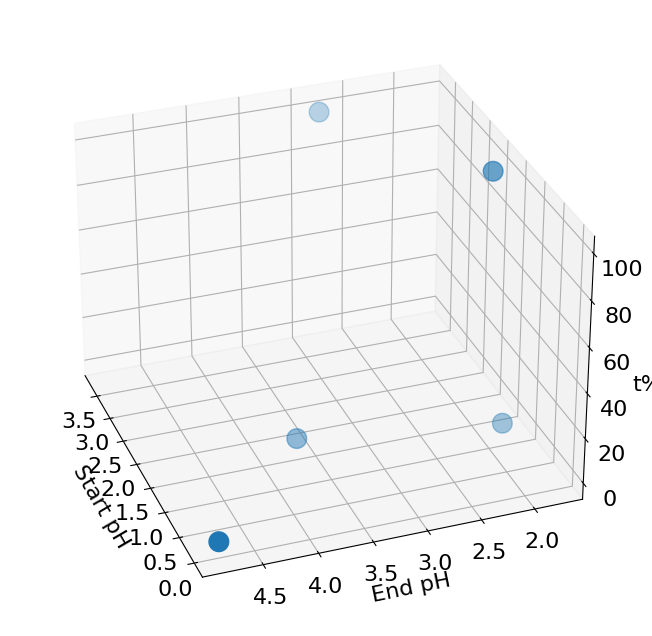

In [17]:
#The experiments done can be visualised in 3D

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
# plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(R2['Start pH'],
             R2['End pH'],
             R2['%t'],
           s=200)
ax.set_xlabel('Start pH')
ax.set_ylabel('End pH')
ax.set_zlabel('t%');
ax.view_init(30, 160)
#plt.show()

Now lets analyse the main effect of start pH, end pH and the time of addition of the acid (%t) on the particle size. 

(How do we deal wiht this standard deviation from measurement?)


In [ ]:
# Compute the mean effect of the factor on the response,
# conditioned on each variable
labels = ['A','B','C']

main_effects = {}
rep=4
for j in range(0,rep):
    index=j+1
    for key in labels:
        effects = result.groupby(key)['y'+str(index)].mean()
        main_effects[j,key] = sum( [i*effects[i] for i in [-1,1]])
        
print('Main effects')    
print(main_effects)


KeyError: 'A'